# Nonlinear computations in spiking neural networks through multiplicative synapses - Figure 3
Michele Nardin, James W Phillips, William F Podlaski, Sander W Keemink

We will here reproduce the main figures from the paper.

### Imports

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Plot settings

In [3]:
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['figure.dpi'] = 90

## Set up the problem

parameters for the double pendulum

In [4]:
m1=1 # mass above
m2=0.5 # mass below
l=1 #length
g=9.81 # gravity
# constants
k1 = 6/(7*m1*l**2)
k2 = 6/(7*m2*l**2)

c1 = -1/2*m1*l**2*k1**2
c2 = -1/2*m2*l**2*k2**2

c = -1/2*m1*l**2

write the system as a Kronecker product 
$$ y' = Ay + C y^{\otimes 3}$$


In [5]:
A = np.array([[0,0,k1*2,-3*k1],
              [0,0,-3*k2,8*k2],
              [3*c*g/l,0,0,0],
              [0,c*g/l,0,0]])

C = np.array([[0]*64,
              [0]*64,
              [0]*40 + [-6,6,0,0,25,-25] + [0]*14 + [-24,24,0,0], 
              [0]*40 + [6,-6,0,0,-25,25] + [0]*14 + [24,-24,0,0]
             ]) * np.array([[1,1,c1,c2]]).T

## Compute solution using 3rd order synapses

In [9]:
Time = 10 # total time
dt = 0.0001 # time step
Nt=int(Time/dt)
print('Total time steps = ', Nt)

Total time steps =  100000


Network parameters

In [28]:
K = 4 # dimensions of the problem
N = 20 # number of neurons for double pendulum
# decoding matrix - linearly spaced
Ds = np.sin(np.linspace(0,2.5*np.pi,int(5*20/8)+1))
D = np.zeros([K,N])
D[0,:10] = Ds[:10]
D[1,:10] = Ds[-11:-1]
D[2,10:20] = Ds[:10]
D[3,10:20] = Ds[-11:-1]
D=D/400
# threshold
T = np.diag(D.T@D)/2

# decay constant of rate
tau=5

Initialization

In [11]:
# initialize it
s_o = np.zeros(N)
r_o = np.ones(N)
x_o = np.array([-0.01353916, -0.0133675 , -1.13912921, -0.17027103])
r_o = np.array(np.linalg.pinv(D)@x_o) # pseudo-inverse


# Voltage, spikes, rate
V = np.zeros([N,Nt+1])
s = np.zeros([N,Nt+1])
r = np.zeros([N,Nt+1])

#initial conditions
V[:,0] = T/2
r[:,0] = r_o
s[:,0] = s_o

recurrent connections

In [31]:
O_f = D.T @ D
O_s = D.T @ (tau*np.identity(K) + A) @ D
O_nl =D.T @ C @ np.kron(D,np.kron(D,D))

Simulation

In [12]:
for t in range(Nt):
    V[:,t+1] = V[:,t] + dt*(-tau*V[:,t] 
                            - O_f@s[:,t] 
                            + O_s @ r[:,t] 
                            + O_nl @ np.kron(r[:,t],np.kron(r[:,t],r[:,t])))
    above = np.where(V[:,t+1] > T)[0]
    # introduce a control to let only one neuron fire
    if len(above):
        s[np.argmax(V[:,t+1]),t+1] = 1/dt
    r[:,t+1] = r[:,t] + dt*(s[:,t+1] - tau*r[:,t])

In [17]:
X=D@r #decode

Plotting

In [15]:
def pend(X,off=0,col1='red',col2='blue',alpha=1):
    x1 = np.sin(X[0])/2
    y1 = -np.cos(X[0])/2
    
    x2 =  (np.sin(X[0]) + 0.5*np.sin(X[1]))
    y2 = -(np.cos(X[0]) + 0.5*np.cos(X[1]))
    
    plt.plot([0+off,2*x1+off],[0,2*y1],col1,alpha=alpha)
    plt.plot([2*x1+off,2*(x2-x1)+off],[2*y1,2*(y2-y1)],col2,alpha=alpha)
#     plt.plot([2*x1,x2],[2*y1,y2])
    plt.xlim([-2,2])
    plt.ylim([-2,2])

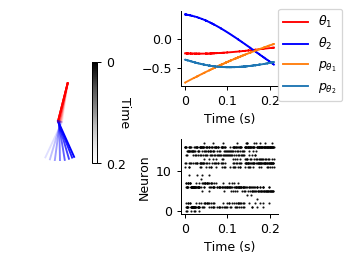

In [18]:
plt.figure(figsize=(4,3))
ns=8

plt.subplot(1,2,1)
plt.imshow([[0,1]],cmap='Greys')
for i in range(ns):
    pend(X[:,300*(i)+2000],alpha=1*(ns-i)/ns)
    plt.subplots_adjust(wspace=-0)
plt.xlim([-1.5,0.5])
plt.ylim([-2,0.5])
plt.axis('off')
cbar = plt.colorbar(shrink=0.5,ticks=[0,1])
cbar.ax.set_yticklabels(['0.2','0'])
cbar.ax.set_ylabel('Time',rotation=270)

ax=plt.subplot(2,2,4)
a=np.where(s[:,2000:150*(i)+2000])
plt.scatter(a[1],a[0],marker='.',color='k',alpha=0.9,s=2)
plt.xticks([0,500,1000],[0,0.1,0.2])
plt.xlabel('Time (s)')
plt.ylabel('Neuron')
[ax.spines[s].set_visible(False) for s in ['right','top']]

ax=plt.subplot(2,2,2)
plt.plot(X[0][2000:300*(i)+2000],c='red',label=r'$ \theta_1$') # theta_1
plt.plot(X[1][2000:300*(i)+2000],c='blue',label=r'$ \theta_2$') # theta_2

plt.plot(X[2][2000:300*(i)+2000],c='tab:orange',label=r'$ p_{\theta_1}$') #first momentum
plt.plot(X[3][2000:300*(i)+2000],c='tab:blue',label=r'$ p_{\theta_2}$') #second momentum
plt.legend(loc=(1,-0.2))
plt.xticks([0,1000,2000],[0,0.1,0.2])
plt.xlabel('Time (s)')
[ax.spines[s].set_visible(False) for s in ['right','top']]

plt.tight_layout()

## Utilize 2 Networks in parallel so to use only 2nd order synapses

First network, the one that actually does the computation

The parameters and decoding matrix are exactly as the one above

In [20]:
# Voltage, spikes, rate: this will do the computation
V = np.zeros([N,Nt+1])
s = np.zeros([N,Nt+1])
r = np.zeros([N,Nt+1])

#initial conditions
V[:,0] = T/2
r[:,0] = r_o
s[:,0] = s_o

# decay constant of rate
tau=5

Second network that constantly represent $X \otimes X$ so to avoid third order

In [19]:
# need a network that represents X (x) X
# need to do it as well as possible!!

Np = 200 # neurons

# dimensionality
Kp = K**2

# kernel
np.random.seed(42)
Dp=np.random.randn(Kp,Np) # N x K
Dp = Dp / np.sqrt(np.diag(Dp.T@Dp))
Dp = Dp / 200
# threshold
Tp = np.diag(Dp.T@Dp)/2
# tau
taup=5

Voltage, spikes, rate for second network

In [21]:
Vp = np.zeros([Np,Nt+1])
sp = np.zeros([Np,Nt+1])
rp = np.zeros([Np,Nt+1])
rp[:,0] = np.array(np.linalg.pinv(Dp)@np.kron(x_o,x_o)) # pseudo-inverse
Vp[:,0] = 0.9*Tp

Connectivty

In [27]:
O_fp = -Dp.T @ Dp
O_x = Dp.T@np.kron(D,D)
# recurrent connections
O_f = D.T @ D
O_s = D.T @ (tau*np.identity(K) + A) @ D
O_nl =D.T @ C @ np.kron(D,Dp)

Simulation

In [22]:
for t in range(Nt):
    ## computation - first network
    V[:,t+1] = V[:,t] + dt*(-tau*V[:,t] 
                            - O_f@s[:,t] 
                            + O_s @ r[:,t] 
                            + O_nl @ np.kron(r[:,t],rp[:,t]))
    above = np.where(V[:,t+1] > T)[0]
    # introduce a control to let only one neuron fire
    if len(above):
        s[np.argmax(V[:,t+1]),t+1] = 1/dt
    r[:,t+1] = r[:,t] + dt*(s[:,t+1] - tau*r[:,t])
    
    ## Kronecker representation of output - second network
    Vp[:,t+1] = Vp[:,t] + dt*(-taup*Vp[:,t]
                              + O_fp @ sp[:,t]
                              + O_x @ (np.kron(r[:,t],s[:,t+1])
                                      +np.kron(s[:,t+1],r[:,t])
                                      +np.kron(r[:,t],r[:,t])*(taup-2*tau)))
    above = np.where(Vp[:,t+1] > Tp)[0]
    # introduce a control to let only one neuron fire
    if len(above):
        sp[np.argmax(Vp[:,t+1]),t+1] = 1/dt
    rp[:,t+1] = rp[:,t] + dt*(sp[:,t+1] - taup*rp[:,t])

In [23]:
X_nt=D@r #decode

Now compare this and the solution above, also against theoretical solution

In [25]:
from scipy.integrate import odeint
def f(X, t):  
    return A@X + C@ np.kron(np.kron(X,X),X)
t = np.arange(0.0, 10, dt)
x_o = np.array([-0.01353916, -0.0133675 , -1.13912921, -0.17027103])
Xt = odeint(f, x_o, t) # approximate numerically the solution

Plot the overlap

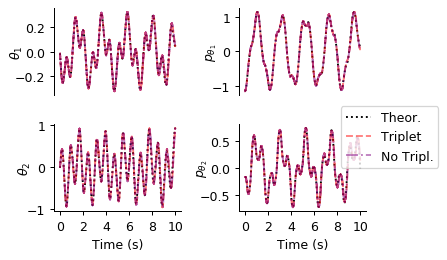

In [26]:
plt.figure(figsize=(5,3))

ax=plt.subplot(2,2,1)

plt.plot(Xt[:,0],color='k',ls='dotted')
plt.plot(X[0],color='red',alpha=0.5,ls='dashed')
plt.plot(X_nt[0],color='purple',alpha=0.5,ls='-.')
[ax.spines[s].set_visible(False) for s in ['right','top','bottom']]
plt.xticks([])
plt.yticks([-0.2,0,0.2])
plt.ylabel(r'$\theta_1$',labelpad=-8)

ax=plt.subplot(2,2,3)

plt.plot(Xt[:,1],color='k',ls='dotted')
plt.plot(X[1],color='red',alpha=0.5,ls='dashed')
plt.plot(X_nt[1],color='purple',alpha=0.5,ls='-.')
[ax.spines[s].set_visible(False) for s in ['right','top']]
plt.ylabel(r'$\theta_2$',labelpad=-5)
plt.xticks(np.arange(6)*2/dt,np.arange(6)*2)

plt.xlabel('Time (s)')

ax=plt.subplot(2,2,2)

plt.plot(Xt[:,2],color='k',ls='dotted')
plt.plot(X[2],color='red',alpha=0.5,ls='dashed')
plt.plot(X_nt[2],color='purple',alpha=0.5,ls='-.')
[ax.spines[s].set_visible(False) for s in ['right','top','bottom']]
plt.xticks([])
plt.ylabel(r'$p_{\theta_1}$',labelpad=-6)

ax=plt.subplot(2,2,4)

plt.plot(Xt[:,3],color='k',ls='dotted',label='Theor.')
plt.plot(X[3],color='red',alpha=0.5,ls='dashed',label='Triplet')
plt.plot(X_nt[3],color='purple',alpha=0.5,ls='-.',label='No Tripl.')
[ax.spines[s].set_visible(False) for s in ['right','top']]
plt.ylabel(r'$p_{\theta_2}$',labelpad=-8)
plt.xticks(np.arange(6)*2/dt,np.arange(6)*2)

plt.xlabel('Time (s)')
plt.legend(loc=(0.8,0.5))
plt.tight_layout()